# Unisolar Projet: Modeling
---

## Imports

In [92]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.metrics import mean_squared_error, mean_absolute_error

## Loading data

In [25]:
df_preprocess = pd.read_csv('preprocessed_data.csv', index_col='Timestamp', parse_dates=['Timestamp'])
df_preprocess['WindDirection'] = df_preprocess['WindDirection'].astype('category')

In [26]:
df_preprocess.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 61343 entries, 2020-01-01 00:15:00 to 2021-09-30 23:45:00
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   SolarGeneration   61343 non-null  float64 
 1   AirTemperature    61343 non-null  float64 
 2   RelativeHumidity  61343 non-null  float64 
 3   WindSpeed         61343 non-null  float64 
 4   WindDirection     61343 non-null  category
dtypes: category(1), float64(4)
memory usage: 2.4 MB


In [27]:
df_preprocess.head()

,SolarGeneration,AirTemperature,RelativeHumidity,WindSpeed,WindDirection
Timestamp,,,,,
2020-01-01 00:15:00,0.0,13.860000,50.200000,15.28,S
2020-01-01 00:30:00,0.0,13.593333,51.600000,13.60,SE
2020-01-01 00:45:00,0.0,13.400000,53.000000,12.88,SE
2020-01-01 01:00:00,0.0,13.193333,54.866667,13.60,S
2020-01-01 01:15:00,0.0,13.200000,56.200000,14.80,S


Lets resample the data to 1 hour time steps instead of 15 minutes

In [38]:
df_preprocess_resampled = df_preprocess.resample('1h').agg({"SolarGeneration": "mean",
                                                            "AirTemperature": "mean",
                                                            "RelativeHumidity": "mean",
                                                            "WindSpeed": "mean",
                                                            "WindDirection": lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan})

df_preprocess_resampled['WindDirection'] = df_preprocess_resampled['WindDirection'].astype('category')

## Train Test Split

We will first create a simple train/validation/test split on the data.

In [40]:
def train_valid_test_split(df: pd.DataFrame, train_timestamp: str, test_timestamp: str) -> tuple:
    """
    Splits the DataFrame into training, validation, and test sets based on timestamp values: training for timestamp < train_timestamp,
    validation for train_timestamp <= timestamp < test_timestamp and test for test_timestamp <= timestamp.

    Parameters:
    - df (DataFrame): The DataFrame containing the data.
    - train_timestamp (str): The timestamp value used to split data into the training set.
    - test_timestamp (str): The timestamp value used to split data into the test set.

    Returns:
    tuple: A tuple containing X_train, y_train, X_valid, y_valid, X_test, y_test.

    - X_train (DataFrame): Features for the training set.
    - y_train (Series): Target variable for the training set.
    - X_valid (DataFrame): Features for the validation set.
    - y_valid (Series): Target variable for the validation set.
    - X_test (DataFrame): Features for the test set.
    - y_test (Series): Target variable for the test set.

    Example:
    X_train, y_train, X_valid, y_valid, X_test, y_test = train_test_valid_split(data, '2020-01-01', '2021-03-01')
    """    
    X_train = df[df.index < train_timestamp].copy()
    y_train = X_train.pop('SolarGeneration')
    
    X_valid = df[(df.index >= train_timestamp) & (df.index < test_timestamp)].copy()
    y_valid = X_valid.pop('SolarGeneration')
    
    X_test = df[df.index >= test_timestamp].copy()
    y_test = X_test.pop('SolarGeneration')
    
    return X_train, y_train, X_valid, y_valid, X_test, y_test

In [41]:
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(df_preprocess_resampled, "2021", "2021-07")

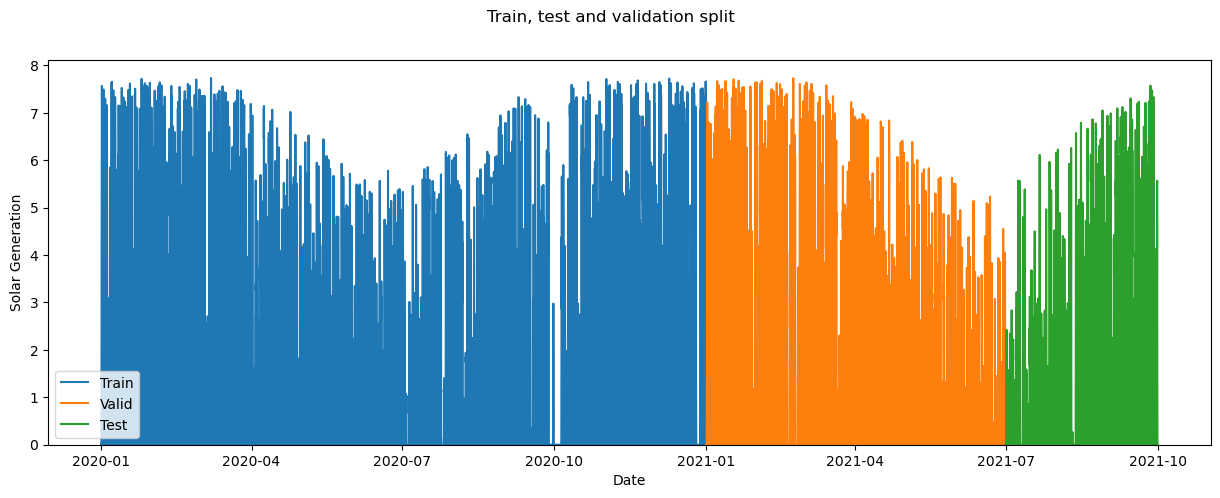

In [42]:
fig, ax = plt.subplots(1, figsize=(15,5))
ax.plot(y_train, label='Train')
ax.plot(y_valid, label='Valid')
ax.plot(y_test, label='Test')
ax.legend(loc='lower left')
ax.set_ylabel('Solar Generation')
ax.set_xlabel('Date')
ax.set_ylim(0)
fig.suptitle("Train, test and validation split");

## Preprocessing

We need to apply two preprocessing steps to the data: `StandardScaler` to the numerical features `AirTemperature`,	`RelativeHumidity` and `WindSpeed`, and one-hot enconding to `WindDirection`.

In [43]:
X_train.head()

,AirTemperature,RelativeHumidity,WindSpeed,WindDirection
Timestamp,,,,
2020-01-01 00:00:00,13.617778,51.600000,13.920000,SE
2020-01-01 01:00:00,12.995000,57.416667,13.360000,S
2020-01-01 02:00:00,12.391667,64.900000,10.646667,S
2020-01-01 03:00:00,12.116667,70.000000,10.960000,S
2020-01-01 04:00:00,13.078333,66.000000,15.405000,S


In [44]:
column_transformer = ColumnTransformer(
    [('ohe', OneHotEncoder(), ['WindDirection'])],
    remainder=StandardScaler()
)

In [45]:
X_train = column_transformer.fit_transform(X_train)
X_valid = column_transformer.transform(X_valid)
X_test = column_transformer.transform(X_test)

## Naive forecasting

The base model we will use is a naive forecasting model using the value from the day before at the same time as a prediction.

In [76]:
naive_predictions = y_test.shift(#,fill_value=0)

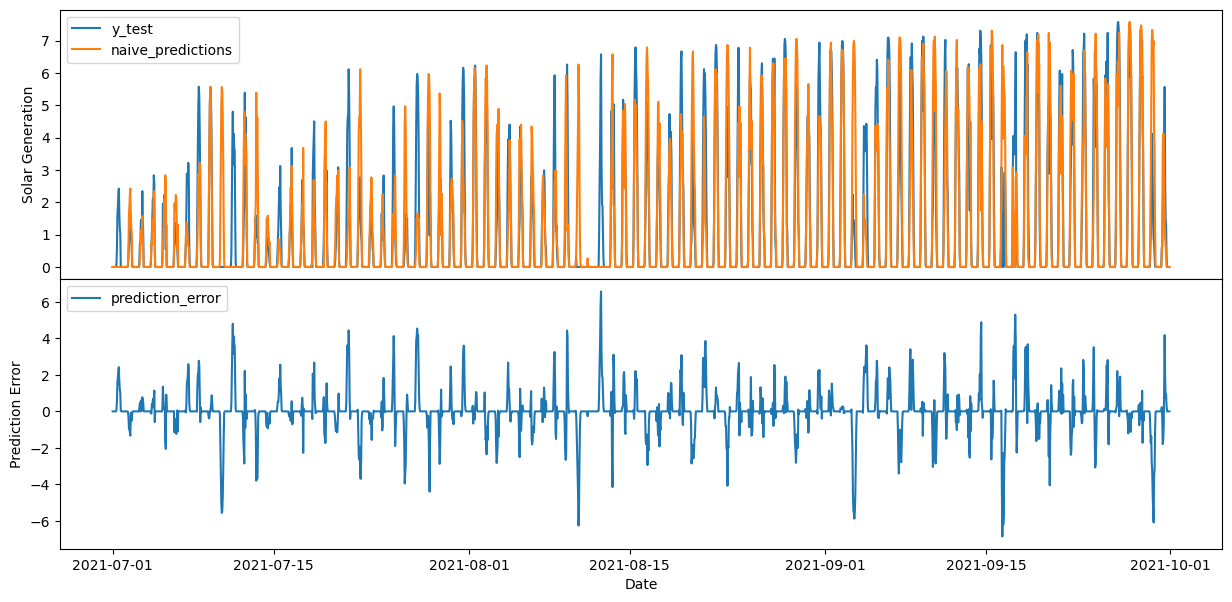

In [95]:
fig, axs = plt.subplots(2, 1, figsize=(15,7), sharex=True)
fig.subplots_adjust(hspace=0)
axs[0].plot(y_test.index, y_test, label='y_test')
axs[0].plot(naive_predictions.index, naive_predictions, label='naive_predictions')
axs[1].plot(y_test.index,y_test-naive_predictions, label='prediction_error')

axs[1].set_xlabel('Date')
axs[0].set_ylabel('Solar Generation')
axs[1].set_ylabel('Prediction Error')

axs[0].legend(loc=('upper left'))
axs[1].legend(loc=('upper left'));

In [96]:
print('Mean squared error:', mean_squared_error(y_test, naive_predictions))
print('Mean absolute error:', mean_absolute_error(y_test, naive_predictions))

Mean squared error: 1.275343252264935
Mean absolute error: 0.510818260303442


## RNN